# Regression Model Exercises

Using the data on a dataset of your choice, complete the following:

In [28]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.feature_selection import RFE

from prepare import min_max_scaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
from wrangle import wrangle_country

In [3]:
df = wrangle_country()
df.head()

,SurfaceArea,Population,GNP,LifeExpectancy
0,193.0,103000,828.0,78.4
1,652090.0,22720000,5976.0,45.9
2,1246700.0,12878000,6648.0,38.3
3,96.0,8000,63.2,76.1
4,28748.0,3401200,3205.0,71.6


In [4]:
df.shape

(222, 4)

### Q1. Split the data into train, validate, and test datasets.

In [5]:
# We will be creating a model that uses SurfaceArea, Population, and GNP to predict LifeExpectancy
train_validate, test = train_test_split(df, test_size = 0.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size = 0.20, random_state = 123)
print(train.shape, validate.shape, test.shape)

(159, 4) (40, 4) (23, 4)


In [6]:
# x df's are all cols except G3
X_train = train.drop(columns=['LifeExpectancy'])
X_validate = validate.drop(columns=['LifeExpectancy'])
X_test = test.drop(columns=['LifeExpectancy'])

# y df's are just G3
y_train = train[['LifeExpectancy']]
y_validate = validate[['LifeExpectancy']]
y_test = test[['LifeExpectancy']]

In [7]:
# Scaling the data
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scaler(X_train, X_validate, X_test)

In [8]:
X_train_scaled.head()

,SurfaceArea,Population,GNP
113,0.176473,0.004382,0.005265
196,0.048954,0.003485,0.000517
200,0.016409,0.007498,0.002353
78,0.002813,0.000349,0.000033
210,0.000039,0.000084,0.000033


Text(0, 0.5, 'Count')

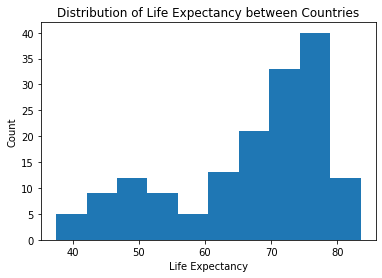

In [9]:
plt.hist(y_train.LifeExpectancy)
plt.title('Distribution of Life Expectancy between Countries')
plt.xlabel('Life Expectancy')
plt.ylabel('Count')

### Q2. Create several regression models to predict the target (Life Expectancy)

In [10]:
y_train.shape

(159, 1)

In [11]:
# Create a baseline with median
baseline_prediction = y_train.LifeExpectancy.median()
baseline_prediction

70.4

In [12]:
baseline_rmse = math.sqrt(mean_squared_error(y_train, np.full(159, np.median(y_train.LifeExpectancy))))
baseline_rmse

12.13375923642575

In [13]:
# Create a baseline with mean
baseline_prediction = y_train.LifeExpectancy.mean()
baseline_prediction

66.79182389937108

In [14]:
baseline_rmse = math.sqrt(mean_squared_error(y_train, np.full(159, np.mean(y_train.LifeExpectancy))))
baseline_rmse

11.584868511743988

Our **baseline** model will use **mean**, predicting that Life Expectancy will be 66.792 in each country. 

Using this prediction gives us a **RMSE** of **11.58**

#### Linear Regression

In [15]:
lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [16]:
lm_pred = lm.predict(X_train_scaled)
lm_pred[0:5]

array([[66.03263529],
       [66.45404567],
       [66.63959012],
       [66.63463606],
       [66.64615448]])

In [17]:
# compute root mean squared error
lm_mse = mean_squared_error(y_train, lm_pred)
lm_rmse = math.sqrt(lm_mse)
lm_rmse

11.444403772788714

In [18]:
evaluate_lm = pd.DataFrame()
evaluate_lm['y'] = y_train.LifeExpectancy
evaluate_lm['baseline'] = y_train.LifeExpectancy.mean()
evaluate_lm['baseline_residual'] = evaluate_lm.baseline - evaluate_lm.y
evaluate_lm["yhat"] = lm_pred
evaluate_lm["model_residual"] = evaluate_lm.yhat - evaluate_lm.y
evaluate_lm.head()

,y,baseline,baseline_residual,yhat,model_residual
113,75.5,66.791824,-8.708176,66.032635,-9.467365
196,60.9,66.791824,5.891824,66.454046,5.554046
200,73.7,66.791824,-6.908176,66.639590,-7.060410
78,53.6,66.791824,13.191824,66.634636,13.034636
210,72.3,66.791824,-5.508176,66.646154,-5.653846


In [19]:
baseline_sse = (evaluate_lm.baseline_residual**2).sum()
model_sse = (evaluate_lm.model_residual**2).sum()

if model_sse < baseline_sse:
    print("Our model beats the baseline")
    print("It makes sense to evaluate this model more deeply.")
else:
    print("Our baseline is better than the model.")

print("Baseline SSE", baseline_sse)
print("Model SSE", model_sse)

Our model beats the baseline
It makes sense to evaluate this model more deeply.
Baseline SSE 21339.25937106918
Model SSE 20824.92605662467


In [20]:
mse = mean_squared_error(evaluate_lm.y, evaluate_lm.yhat)
rmse = math.sqrt(mse)

print("SSE is", model_sse, " which is the sum sf squared errors")
print("MSE is", mse, " which is the average squared error")
print("RMSE is", rmse, " which is the square root of the MSE")

SSE is 20824.92605662467  which is the sum sf squared errors
MSE is 130.97437771462057  which is the average squared error
RMSE is 11.444403772788714  which is the square root of the MSE


In [29]:
lm_r2 = r2_score(evaluate_lm.y, evaluate_lm.yhat)
print('R-squared = ', round(lm_r2,3))

R-squared =  0.024


In [23]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

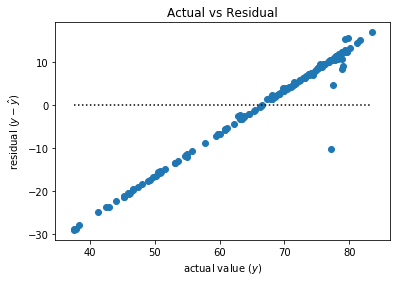

In [24]:
plot_residuals(evaluate_lm.y, evaluate_lm.yhat)

#### Lasso_Lars

In [25]:
lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train)

LassoLars(alpha=0.1, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [26]:
lars_pred = lars.predict(X_train_scaled)

In [27]:
lars_rmse = math.sqrt(mean_squared_error(y_train, lars_pred))
lars_rmse

11.526999760262923

#### Polynomial Features (Degree = 2) + Linear Regression

In [31]:
# make the polynomial thing
pf = PolynomialFeatures(degree=2)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)
# X_validate_squared

In [32]:
# feed that data into our linear model. 
# make the thing
lm_squared = LinearRegression()
lm_squared.fit(X_train_squared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
lm_squared_pred = lm_squared.predict(X_train_squared)

In [34]:
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**1/2
lm_squared_rmse

53.227164665287106

#### Polynomial Features (Degree = 3) + Linear Regression

In [35]:
# make the polynomial thing
pf = PolynomialFeatures(degree=3)

# fit and transform the thing
# to get a new set of features..which are the original features sqauared
X_train_cubed = pf.fit_transform(X_train_scaled)
X_validate_cubed = pf.transform(X_validate_scaled)

In [36]:
# feed that data into our linear model. 
# make the thing
lm_cubed = LinearRegression()
lm_cubed.fit(X_train_cubed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
lm_cubed_pred = lm_cubed.predict(X_train_cubed)

In [38]:
lm_cubed_rmse = mean_squared_error(y_train, lm_cubed_pred)**1/2
lm_cubed_rmse

42.34948011946948

### Q3. Check for Overfitting Using the Validate Data

In [39]:
# Linear Regression
lm_pred_v = lm.predict(X_validate_scaled)
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**1/2
lm_rmse_v

60.49238460491706

In [40]:
# LassoLars
lars_pred_v = lars.predict(X_validate_scaled)
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**1/2
lars_rmse_v

63.83162339194071

In [41]:
# Squared Regression
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**1/2
lm_squared_rmse_v

194.9280936677742

In [42]:
# Cubed Regression
lm_cubed_pred_v = lm_cubed.predict(X_validate_cubed)
lm_cubed_rmse_v = mean_squared_error(y_validate, lm_cubed_pred_v)**1/2
lm_cubed_rmse_v

854174.6450130607

None of these models perform better than baseline. There may be no meaningful relationship between GDP/SurfaceArea/Population and LifeExpectancy.